# Avaliando Clustering

Avaliar clusters é uma tarefa difícil que requer não somente um índice (score) para ser realizada. Este notebook foca em realizar um estudo sobre algumas métricas utilizadas nessa avaliação.


In [ ]:
!pip install --upgrade scikit-learn

## Dataset

Para iniciar o estudo, vamos gerar um dataset dividido em classes e algumas predições de modelos.

In [1]:
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering

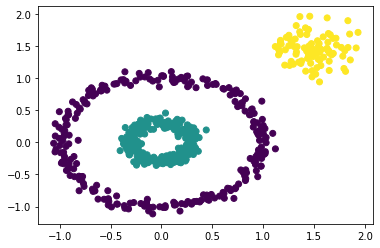

In [2]:
# Gerando dataset
X, y = make_circles(random_state=214, noise=.05, factor=.3, n_samples=500)
_ = make_blobs(centers=[(1.5,1.5)], cluster_std=.2)
X = np.append( X, _[0], axis=0 )
y = np.append( y, _[1]+2, axis=0 )
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

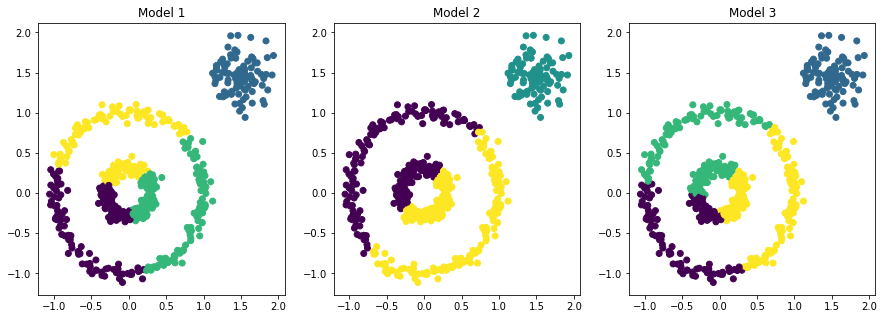

In [3]:
# Gerando predições
y_1 = KMeans(n_clusters=4, random_state=214).fit_predict(X)
y_2 = SpectralClustering(n_clusters=3).fit_predict(X)
y_3 = SpectralClustering(n_clusters=4).fit_predict(X)


fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(15,5))
axs[0].scatter(X[:, 0], X[:, 1], c=y_1, label=['1','2','3'])
axs[0].set_title("Model 1")
axs[1].scatter(X[:, 0], X[:, 1], c=y_2)
axs[1].set_title("Model 2")
axs[2].scatter(X[:, 0], X[:, 1], c=y_3)
axs[2].set_title("Model 3")
plt.show()

## Matriz de contingências

A matriz de contingências é uma forma de visualizar a distribuição das classes reais do conjunto de dados ao longo dos clusters. Ela é uma matriz $m \times k$, onde $m$ é  número de classes originais e $k$, o número de clusters. Sua entrada $M_{ij}$ representa a quantidade de entradas de classe $i$ que estão no cluster $j$.

Vamos visualizar a matriz de contingências das predições $y_1$

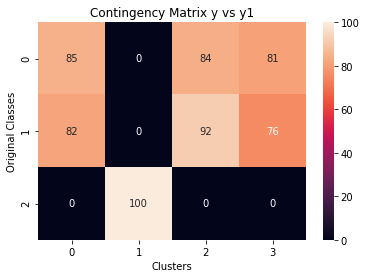

In [4]:
from sklearn.metrics.cluster import contingency_matrix
from seaborn import heatmap

M1 = contingency_matrix(y, y_1)
ax = heatmap(M1, annot=True, fmt="d")
ax.set_xlabel("Clusters")
ax.set_ylabel("Original Classes")
ax.set_title("Contingency Matrix y vs y1")
plt.show()

## Pureza

**Pureza** é uma **métrica supervisionada** que considera a classe mais frequênte em cada cluster como classe dominante. O percentual da classe dominante será a Pureza daquele cluster.

$m$ é o número de classes no dataset
$k$ é o número de clusters

Sendo $D = \{d_1, d_2, \dots, d_m\}$, onde $d_i$ representa o conjunto de documentos que pertencem à classe $i$, e $C = \{c_1, c_2, c_3, \dots, c_k \}$ onde $c_j$ representa o número de documentos que pertencem ao cluster $j$, podemos definir a pureza de um cluster $c_j$ como:

$P(c_j) = \frac{1}{|c_j|}\underset{1<i\leq m}{\max} |c_j\cap d_i| $

Vamos calcualar a pureza dos clusters utilizando a matriz de contingências. Basta obter o valor máximo de cada coluna e subtrair pela soma da mesma coluna.

In [5]:
## Obtendo a pureza das predições y_1
P = M1.max(axis=0)/M1.sum(axis=0)

for i in range(len(P)):
  print(f"Cluster {i} purity - {P[i].round(2)}")

Cluster 0 purity - 0.51
Cluster 1 purity - 1.0
Cluster 2 purity - 0.52
Cluster 3 purity - 0.52


Os resultados encontrados batem com o que observamos nas figuras acima. No modelo 1, o cluster 0 possui  documentos de somente uma classe, enquanto as outras classes ficam igualmente distribuiídas entre os 3 outros clusters.

## Normalized Mutual Info

**NMI** é também uma métrica **supervisionada** que nos ajuda a comparar o ajuste de um conjunto de clusters a um conjunto de classes. Ela se baseia na teoria da informação e em probabilidades.

$\displaystyle \text{NMI}(D, C) = \frac{I(D,C)}{[H(D)+H(C)]/2}$

Onde $I(D,C)$ é a _informação mútua_ entre as classes e os clusters.

$\displaystyle I(D,C) = \sum_{i}\sum_{j} P(d_i\cap c_j)\log\frac{P(d_i\cap c_j)}{P(d_i)P(c_j)}$

E $H(D)$ a entropia das distribuições

$\displaystyle H(D) = - \sum_{j}P(d_j) \log P(d_j) $

A métrica resulta em um único valor final. Vamos testa-la utilizando a implementação do Sklearn.

In [6]:
from sklearn.metrics import normalized_mutual_info_score

s1 = normalized_mutual_info_score(y, y_1)
s2 = normalized_mutual_info_score(y, y_2)
s3 = normalized_mutual_info_score(y, y_3)

print("- NMI -")
print( f"Modelo 1 - {s1}" )
print( f"Modelo 2 - {s2}" )
print( f"Modelo 3 - {s3}" )

- NMI -
Modelo 1 - 0.37691258315477894
Modelo 2 - 0.43883168440864945
Modelo 3 - 0.3808491747176737


A NMI ainda possui algums problemas com relação a um número alto de clusters. Uma outra versão da métrica é proposta para resolver esses problemas, a *Adjusted Normalized Mutual Info* 

## Rand Index

O **Rand Index** é uma métrica que interpreta o clustering efetuado como uma série de decisões tomadas sobre cada par de documentos possível.

Ela propõe o seguinte raciocínio:

Dois documentos devem estar no mesmo cluster se, e somente se, forem similares, i.e., da mesma classe.
- Temos um *Verdadeiro positivo* (**TP**) se dois documentos da mesma classe estão no mesmo cluster
- Temos um *Verdadeiro Negativo* (**TN**) se dois documentos de classes diferentes estão em clusters diferentes
- Um *Falso Positivo* (**FP**) ocorre se dois documentos de classes distintas estão no mesmo cluster
- Um *Falso Negativo* (**FN**) ocorre se dois documentos de classes iguais estão em clusters diferentes

Por fim, o Rand index é calculado da seguinte forma:

$\text{RI} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$





> Existe também uma versão ajustada do RI



In [8]:
from sklearn.metrics import rand_score

ri1 = rand_score(y, y_1)
ri2 = rand_score(y, y_2)
ri3 = rand_score(y, y_3)

print("- Rand Index -")
print( f"Modelo 1 - {ri1}" )
print( f"Modelo 2 - {ri2}" )
print( f"Modelo 3 - {ri3}" )

- Rand Index -
Modelo 1 - 0.6524707846410684
Modelo 2 - 0.6525542570951586
Modelo 3 - 0.6544073455759599


## Silhouette Score

O silhouette score é uma métrica **não-supervisionada** que visa avaliar o quão bem cada entrada se assemelha somente a seu cluster.

Seja $d$ a matriz de distâncias par-a-par das entradas, e $C = \{c_1, c_2, c_3, \dots, c_k\}$ o conjunto de clusters onde $c_j$ representa o grupo de documentos que pertencem ao cluster $j$. 

Inicialmente calculamos o "quão bem" cada entrada está inserida em seu próprio cluster, em outras palavras, a "similaridade" da entrada com seu próprio cluster.

Considerando que a entrada $i$ foi inserida no cluster $j$, o valor da similaridade será

$\displaystyle a(i) = \frac{1}{|C_j|-1}\sum_{k\in C_j, k\ne j}{d_{i,k}}$

Quanto menor o $a(i)$, melhor.

Na sequência, calculamos a semelhança da mesma entrada a todos os outros clusters, guardando apenas a melhor de todas (a menor). Esta etapa pode ser entendida como encontrar o cluster mais semelhante à entrada $i$ que não seja o seu próprio.

$\displaystyle b(i) = \underset{l \ne j}{\min} \frac{1}{|C_l|}\sum_{k\in C_l}{d_{i,k}}$

Por fim, definimos os Silhouette score como:

$\displaystyle s(i) = \frac{b(i)-a(i)}{\max\{b(i),a(i)\} }$

> $-1 \leq s(i) \leq 1$

O silhouette score calcula o grau de ajuste para cada uma das entradas, portanto, para avaliar a clusterização de forma geral, calculamos a média ou visualizamos o plot de silhouettes.

In [10]:
from sklearn.metrics import silhouette_score, silhouette_samples

s1 = silhouette_score(X, y_1)
s2 = silhouette_score(X, y_2)
s3 = silhouette_score(X, y_3)

print("- Silhouette scores -")
print( f"Modelo 1 - {s1}" )
print( f"Modelo 2 - {s2}" )
print( f"Modelo 3 - {s3}" )

- Silhouette scores -
Modelo 1 - 0.3973529569675022
Modelo 2 - 0.37909475064364634
Modelo 3 - 0.39313560806366754


Silhouette plot para as predições $y_1$

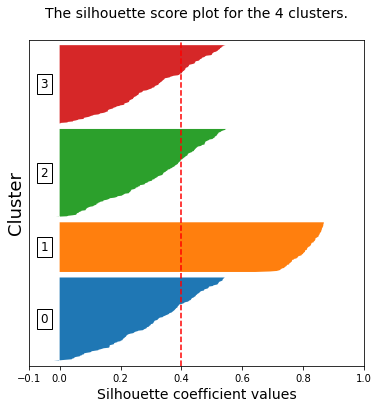

In [16]:
def plot_silhouette_samples(X, pred_labels):
  n_clusters = len(np.unique(pred_labels))

  fig, (ax) = plt.subplots(1, 1, figsize=(6,6))
  
  ax.set_xlim([-0.1, 1])
  ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  silhouette_avg = silhouette_score(X, pred_labels)
  sample_silhouette_values = silhouette_samples(X, pred_labels)

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[pred_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
  
    ax.fill_betweenx(np.arange(y_lower, y_upper), 
                     0, ith_cluster_silhouette_values )
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            ha='center', va='center', fontsize=12,
            bbox={'boxstyle':'square',
                  'facecolor':'white'})
    y_lower = y_upper + 10
  

  ax.set_title(f"The silhouette score plot for the {n_clusters} clusters.\n",fontsize=14)
  ax.set_xlabel("Silhouette coefficient values",fontsize=14)
  ax.set_ylabel("Cluster",fontsize=18)
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax.set_yticks([])
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  return ax

plot_silhouette_samples(X, y_1)
plt.show()

**Referências**

Evaluation of clustering, Sanford:
https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html

Scikit-Learn, Metrics, Cluster:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.cluster

Scikit-Learn, Silhouette samples plot:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
